In [1]:
# Retail Inventory Optimization Project - Full Python Analysis Script

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set visualization style
sns.set(style="whitegrid")


In [3]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv("retail_inventory_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
print("Dataset loaded with shape:", df.shape)
print(df.head())

Loading dataset...
Dataset loaded with shape: (200, 9)
        Date Store_ID    SKU_ID     Category  Units_Sold  Inventory_On_Hand  \
0 2024-01-01  Store_3  SKU_1004    Groceries          17                196   
1 2024-01-02  Store_1  SKU_1001  Electronics          25                 85   
2 2024-01-03  Store_3  SKU_1001      Apparel          20                 78   
3 2024-01-04  Store_3  SKU_1002    Groceries          12                131   
4 2024-01-05  Store_1  SKU_1004      Apparel          21                 51   

   Reorder_Point  Supplier_Lead_Time_Days  Reorder_Needed  
0             34                        8           False  
1             40                        5           False  
2             57                       10           False  
3             35                        5           False  
4             36                       14           False  


In [4]:
# Calculate 7-day moving average of units sold per SKU
print("Calculating 7-day moving average...")
daily_sales = df.groupby(['Date', 'SKU_ID'])['Units_Sold'].sum().reset_index()
daily_sales['7D_MA_Units_Sold'] = daily_sales.groupby('SKU_ID')['Units_Sold'].transform(lambda x: x.rolling(window=7).mean())


Calculating 7-day moving average...


In [5]:
# Merge back with main dataframe
df = pd.merge(df, daily_sales[['Date', 'SKU_ID', '7D_MA_Units_Sold']], on=['Date', 'SKU_ID'], how='left')
print("Merged dataset sample:")
print(df.head())

# Flag SKUs needing reorder
df['Reorder_Needed'] = df['Inventory_On_Hand'] < df['Reorder_Point']

Merged dataset sample:
        Date Store_ID    SKU_ID     Category  Units_Sold  Inventory_On_Hand  \
0 2024-01-01  Store_3  SKU_1004    Groceries          17                196   
1 2024-01-02  Store_1  SKU_1001  Electronics          25                 85   
2 2024-01-03  Store_3  SKU_1001      Apparel          20                 78   
3 2024-01-04  Store_3  SKU_1002    Groceries          12                131   
4 2024-01-05  Store_1  SKU_1004      Apparel          21                 51   

   Reorder_Point  Supplier_Lead_Time_Days  Reorder_Needed  7D_MA_Units_Sold  
0             34                        8           False               NaN  
1             40                        5           False               NaN  
2             57                       10           False               NaN  
3             35                        5           False               NaN  
4             36                       14           False               NaN  


In [6]:

# Create summary per SKU
print("Creating SKU-level summary...")
sku_summary = df.groupby('SKU_ID').agg({
    'Units_Sold': 'sum',
    'Inventory_On_Hand': 'mean',
    'Reorder_Point': 'mean',
    'Reorder_Needed': 'sum',
    'Supplier_Lead_Time_Days': 'mean',
    '7D_MA_Units_Sold': 'mean'
}).reset_index()

Creating SKU-level summary...


In [7]:
# Calculate reorder rate and restock recommendation
sku_summary['Reorder_Rate (%)'] = (sku_summary['Reorder_Needed'] / df['SKU_ID'].value_counts().mean()) * 100
sku_summary['Restock_Recommendation'] = sku_summary['Inventory_On_Hand'] < sku_summary['Reorder_Point']
print("Summary created with shape:", sku_summary.shape)
print(sku_summary.head())


Summary created with shape: (5, 9)
     SKU_ID  Units_Sold  Inventory_On_Hand  Reorder_Point  Reorder_Needed  \
0  SKU_1001         969         120.416667      44.666667               0   
1  SKU_1002         670         129.028571      43.200000               0   
2  SKU_1003         771         117.195122      44.097561               0   
3  SKU_1004         949         125.744681      43.723404               0   
4  SKU_1005         574         116.206897      45.137931               0   

   Supplier_Lead_Time_Days  7D_MA_Units_Sold  Reorder_Rate (%)  \
0                 9.000000         20.023810               0.0   
1                 9.942857         19.413793               0.0   
2                 8.756098         18.951020               0.0   
3                 9.595745         20.177700               0.0   
4                 9.103448         20.180124               0.0   

   Restock_Recommendation  
0                   False  
1                   False  
2                   F

Displaying bar chart for units sold per SKU...


/var/folders/bq/5vjrfz8d501bv3f9dl1qhwrm0000gn/T/ipykernel_25166/3299545928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SKU_ID', y='Units_Sold', data=sku_summary, palette='Blues_d')


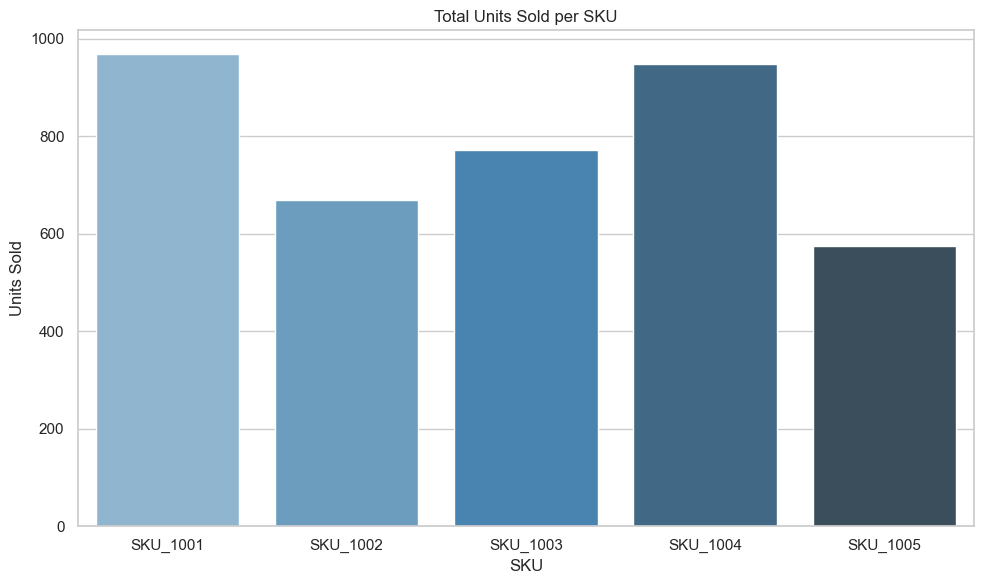

In [8]:
# Visualization 1: Units sold per SKU
print("Displaying bar chart for units sold per SKU...")
plt.figure(figsize=(10, 6))
sns.barplot(x='SKU_ID', y='Units_Sold', data=sku_summary, palette='Blues_d')
plt.title('Total Units Sold per SKU')
plt.xlabel('SKU')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.savefig("units_sold_per_sku.png")
plt.show()

Displaying heatmap for restock recommendation...


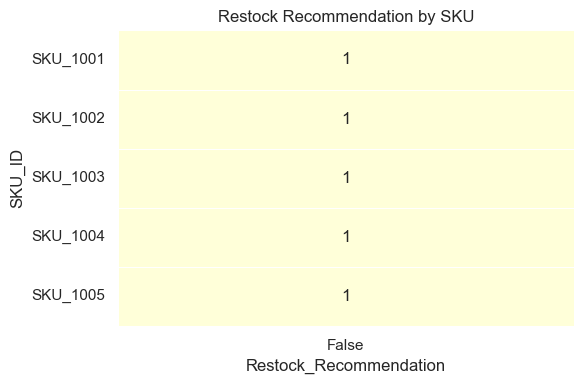

In [9]:
# Visualization 2: Reorder recommendation heatmap
print("Displaying heatmap for restock recommendation...")
plt.figure(figsize=(6, 4))
sns.heatmap(pd.crosstab(sku_summary['SKU_ID'], sku_summary['Restock_Recommendation']),
            cmap="YlGnBu", cbar=False, linewidths=.5, annot=True, fmt='d')
plt.title('Restock Recommendation by SKU')
plt.tight_layout()
plt.savefig("restock_recommendation_heatmap.png")
plt.show()

In [10]:
# Save summary to CSV
summary_path = "inventory_sku_summary.csv"
sku_summary.to_csv(summary_path, index=False)
print(f"Summary CSV saved to: {summary_path}")


Summary CSV saved to: inventory_sku_summary.csv
